In [9]:
from nlp.recipes_utils import *
import sys
import os
import ast
import random
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import torch

# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [10]:
print("Python version: ", sys.version)
print(sys.version_info)

Python version:  3.8.19 (default, Mar 20 2024, 15:27:52) 
[Clang 14.0.6 ]
sys.version_info(major=3, minor=8, micro=19, releaselevel='final', serial=0)


In [11]:
device = set_device()  # Set device to maximize performance

Device set to: mps


In [12]:
clear_memory(device)  # Clear unused memory

In [13]:
# make sure ./data/recipes.pickle exists
!python -c 'from recipes_utils import *; split_and_save_recipe_datasets(preprocess=True)'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
NameError: name 'split_and_save_recipe_datasets' is not defined


In [14]:
# RECIPE DATASET PROCESSING
DIR_DATA_PATH = '../data/recipes'
FULL_RECIPES_PATH = f'{DIR_DATA_PATH}/full_dataset.csv'
FULL_RECIPES_PICKLE_PATH = f'../data/recipes.pickle'
TRAIN_PICKLE_PATH = f'{DIR_DATA_PATH}/train.pickle'
VAL_PICKLE_PATH = f'{DIR_DATA_PATH}/val.pickle'
TEST_PICKLE_PATH = f'{DIR_DATA_PATH}/test.pickle'

KEEP_COLUMNS = ['title', 'ingredients', 'directions', 'NER']

# Special markers to separate the recipe components
MARKER_TITLE = '<t>'
MARKER_INGREDIENTS = '<i>'
MARKER_DIRECTIONS = '<d>'
MARKER_STOP = '_'
MAX_TEXT_LENGTH = 500

In [15]:
full_dataset = load_pickle(FULL_RECIPES_PICKLE_PATH)

In [16]:
# recipes = process_recipe_data(full_dataset)
full_dataset = full_dataset.dropna()
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231141 entries, 0 to 2231141
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   title        object
 1   ingredients  object
 2   directions   object
 3   link         object
 4   source       object
 5   NER          object
dtypes: object(6)
memory usage: 119.2+ MB


In [17]:
def transform_list_to_string(list_str, as_list=True):
    # Parse the string as a list
    parsed_list = ast.literal_eval(list_str)
    # Format as a bulleted list or join with semicolons based on the flag
    if as_list:
        return "\n".join(f"- {item}" for item in parsed_list)
    else:
        return " ".join(parsed_list)


def recipe_to_str(data):
    # Apply the transformation to ingredients and directions with list formatting
    data['ingredients_string'] = data['ingredients'].apply(lambda x: transform_list_to_string(x, as_list=True))
    data['directions_string'] = data['directions'].apply(lambda x: transform_list_to_string(x, as_list=False))

    # Create a new column by concatenating title, ingredients, and directions with specific markers
    data['combined'] = (MARKER_TITLE + "Recipe: " + data['title'] + "\n\n" +
                        MARKER_INGREDIENTS + "Ingredients:\n" + data['ingredients_string'] + "\n\n" +
                        MARKER_DIRECTIONS + "Directions: " + data['directions_string'])

    # Drop intermediate columns used for processing
    data.drop(['ingredients_string', 'directions_string'], axis=1, inplace=True)

    return data

In [18]:
recipes = full_dataset[KEEP_COLUMNS]
recipes = recipe_to_str(recipes)
recipes.head()

/var/folders/v2/czt_wcgn5dl4yzd4vy94xpwh0000gn/T/ipykernel_18417/1096789508.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ingredients_string'] = data['ingredients'].apply(lambda x: transform_list_to_string(x, as_list=True))


,title,ingredients,directions,NER,combined
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",<t>Recipe: No-Bake Nut Cookies\n\n<i>Ingredien...
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom...",<t>Recipe: Jewell Ball'S Chicken\n\n<i>Ingredi...
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",<t>Recipe: Creamy Corn\n\n<i>Ingredients:\n- 2...
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo...",<t>Recipe: Chicken Funny\n\n<i>Ingredients:\n-...
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu...",<t>Recipe: Reeses Cups(Candy) \n\n<i>Ingredie...


In [19]:
# Sample Recipe as string
print(recipes['combined'][0])

<t>Recipe: No-Bake Nut Cookies

<i>Ingredients:
- 1 c. firmly packed brown sugar
- 1/2 c. evaporated milk
- 1/2 tsp. vanilla
- 1/2 c. broken nuts (pecans)
- 2 Tbsp. butter or margarine
- 3 1/2 c. bite size shredded rice biscuits

<d>Directions: In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes.


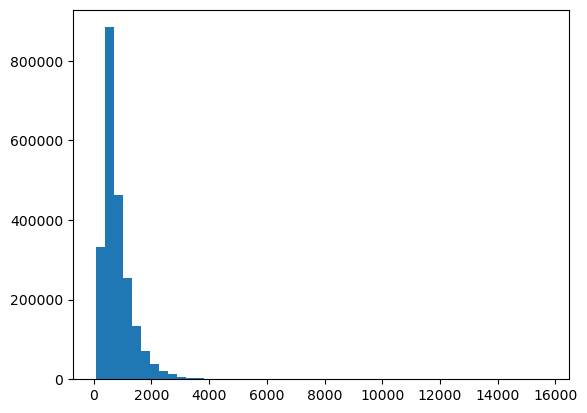

In [20]:
# Check which recipe length is best for sequence length limit
recipe_lengths = [len(recipe_text) for recipe_text in recipes["combined"]]
plt.hist(recipe_lengths, bins=50)
plt.show()

In [21]:
# Filter data based on the maximum text length for specified column. We keep those with MAX_TEXT_LENGTH
recipes_filtered = recipes[recipes['combined'].apply(len) <= MAX_TEXT_LENGTH]
print("Before filtering: ", len(full_dataset))
print("After filtering: ", len(recipes_filtered))

Before filtering:  2231141
After filtering:  736028


In [22]:
##################################################################################################################
# RUN if ./data/recipes/ does not exist 
##################################################################################################################
# Split the dataset into train, val and split
# train_dataset, val_dataset, test_dataset = split_data(recipes, train_size=0.7, val_size=0.15, test_size=0.15)
# 
# # Save the datasets to files
# if not os.path.exists(DIR_DATA_PATH):
#     os.makedirs(DIR_DATA_PATH)
# 
# save_pickle(train_dataset, TRAIN_PICKLE_PATH)
# save_pickle(val_dataset, VAL_PICKLE_PATH)
# save_pickle(test_dataset, TEST_PICKLE_PATH)
# save_pickle(recipes_filtered, DIR_DATA_PATH + '/recipes_processed.pickle')
# 
##################################################################################################################

In [23]:
# Load only a % of entries
# Note: 0.001 approx. 1500+ entries; 0.0001% = 155/33/33; 0.00005% = 78/16/16

keep_pct = 0.0001
# train, val, test = load_splits(TRAIN_PICKLE_PATH, VAL_PICKLE_PATH, TEST_PICKLE_PATH, keep_pct=pct) 

train = load_pickle(TRAIN_PICKLE_PATH)
val = load_pickle(VAL_PICKLE_PATH)
test = load_pickle(TEST_PICKLE_PATH)

train = train.sample(frac=keep_pct, random_state=42)
val = val.sample(frac=keep_pct, random_state=42)
test = test.sample(frac=keep_pct, random_state=42)

print(f'MAX_RECIPE_LENGTH: {MAX_TEXT_LENGTH}')
print(f'TOTAL RECIPES: {len(train) + len(val) + len(test)}')
print(f"- Train: {len(train)} \n"
      f"- Val: {len(val)} \n"
      f"- Test: {len(test)}")

MAX_RECIPE_LENGTH: 500
TOTAL RECIPES: 222
- Train: 156 
- Val: 33 
- Test: 33


In [24]:
# only keep column with recipe texts
train = train["combined"]
val = val['combined']
test = test['combined']

https://www.tensorflow.org/text/tutorials/text_generation

## TOKEN

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

tokenizer.fit_on_texts([MARKER_STOP])
tokenizer.fit_on_texts(train)
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 157,
 'word_counts': '{"_": 1, "<": 468, "t": 4970, ">": 468, "R": 239, "e": 8297, "c": 3064, "i": 5153, "p": 2444, ":": 484, " ": 15378, "C": 309, "r": 4618, "a": 5122, "n": 5038, "b": 1221, "y": 554, "l": 3237, "s": 4235, "h": 2061, "\\n": 1827, "I": 241, "g": 1899, "d": 3039, "-": 1371, "1": 1116, "o": 5170, "2": 596, "u": 2206, "/": 444, ".": 1652, "x": 247, "w": 790, "J": 17, "O": 27, "k": 860, "(": 187, ")": 188, "D": 223, "W": 51, ",": 786, "P": 191, "G": 39, "m": 1547, "A": 185, "f": 887, "S": 280, "4": 261, "3": 290, "v": 603, "T": 143, ";": 84, "M": 137, "B": 177, "0": 164, "Y": 10, "\'": 25, "F": 88, "q": 69, "j": 125, "6": 76, "z": 149, "H": 41, "N": 8, "5": 147, "\\u00b0": 50, "7": 18, "[": 4, "]": 4, "K": 12, "L": 56, "&": 13, "U": 10, "8": 74, "9": 29, "Q": 5, "E": 26, "V": 17, "!": 6, "Z": 3, "\\"": 10, "#": 3, "%": 7, "\\u2019": 1, "\\t": 6}',


In [26]:
# @see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  86


In [27]:
print(tokenizer.index_word[5])
tokenizer.word_index['s']

a


9

In [28]:
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 'o', 'i', 'a', 'n', 't', 'r', 's', 'l', 'c', 'd', 'p', 'u', 'h', 'g', '\n', '.', 'm', '-', 'b', '1', 'f', 'k', 'w', ',', 'v', '2', 'y', ':', '<', '>', '/', 'C', '3', 'S', '4', 'x', 'I', 'R', 'D', 'P', ')', '(', 'A', 'B', '0', 'z', '5', 'T', 'M', 'j', 'F', ';', '6', '8', 'q', 'L', 'W', '°', 'H', 'G', '9', 'O', 'E', "'", '7', 'J', 'V', '&', 'K', 'Y', 'U', '"', 'N', '%', '!', '\t', 'Q', '[', ']', 'Z', '#', '_', '’']


## VECTORIZING FOR RNN

In [29]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_str = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_str = recipe_str.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_str)

In [30]:
train_vectorized = tokenizer.texts_to_sequences(train)
print('Vectorized train size', len(train_vectorized))
print(train_vectorized[0][:10], '...')

Vectorized train size 156
[31, 7, 32, 40, 2, 11, 4, 13, 2, 30] ...


In [31]:
recipe_sequence_to_string(train_vectorized[1])

<t>Recipe: Country Apple Slaw

<i>Ingredients:
- 2 Granny Smith apples, thinly sliced
- 4 cups shredded green cabbage (about 1/2 head)
- 4 cups shredded red cabbage (about 1/2 head)
- 1 cucumber, seeded and sliced
- 3/4 cup dried cherries
- 1/2 cup cider vinegar
- 1/3 cup honey
- 1/3 cup olive oil
- 2 teaspoons salt
- 1/2 teaspoon freshly ground black pepper
- 1/4 cup roasted, salted pepitos (shelled pumpkin seeds)

<d>Directions: Combine apples and next 4 ingredients in a large bowl. Whisk together vinegar and next 4 ingredients in a medium bowl. Toss vinaigrette with apple mixture; cover and chill up to 4 hours. Sprinkle with pepitos.


## PADDING

In [32]:
for i, recipe in enumerate(train_vectorized[:5]):
    print('Recipe #{} length: {}'.format(i + 1, len(recipe)))

Recipe #1 length: 429
Recipe #2 length: 644
Recipe #3 length: 386
Recipe #4 length: 292
Recipe #5 length: 999


In [33]:
# Use -1 and +1 to make sure that all recipes will have at least 1 stop sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).

trainVect_padded_no_stops = tf.keras.preprocessing.sequence.pad_sequences(
    train_vectorized,
    padding='post',
    truncating='post',
    maxlen=MAX_TEXT_LENGTH - 1,
    value=tokenizer.texts_to_sequences([MARKER_STOP])[0]
)

trainVect_padded = tf.keras.preprocessing.sequence.pad_sequences(
    trainVect_padded_no_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_TEXT_LENGTH + 1,
    value=tokenizer.texts_to_sequences([MARKER_STOP])[0]
)

In [34]:
for i, recipe in enumerate(trainVect_padded[:5]):
    print('Recipe #{} length: {}'.format(i, len(recipe)))

Recipe #0 length: 501
Recipe #1 length: 501
Recipe #2 length: 501
Recipe #3 length: 501
Recipe #4 length: 501


In [35]:
recipe_sequence_to_string(trainVect_padded[1])

<t>Recipe: Country Apple Slaw

<i>Ingredients:
- 2 Granny Smith apples, thinly sliced
- 4 cups shredded green cabbage (about 1/2 head)
- 4 cups shredded red cabbage (about 1/2 head)
- 1 cucumber, seeded and sliced
- 3/4 cup dried cherries
- 1/2 cup cider vinegar
- 1/3 cup honey
- 1/3 cup olive oil
- 2 teaspoons salt
- 1/2 teaspoon freshly ground black pepper
- 1/4 cup roasted, salted pepitos (shelled pumpkin seeds)

<d>Directions: Combine apples and next 4 ingredients in a large bowl. Whisk tog  


In [36]:
dataset = tf.data.Dataset.from_tensor_slices(trainVect_padded)
print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(501,), dtype=tf.int32, name=None)>


In [37]:
for recipe in dataset.take(1):
    print('Raw Recipe:\n', recipe.numpy(), '\n\n\n')
    print('Text Recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw Recipe:
 [31  7 32 40  2 11  4 13  2 30  1 34  8  5  6 21  2  8  8 29  1 40  2 10
  4  9 15 17 17 31  4 32 39  6 16  8  2 12  4  2  6  7  9 30 17 20  1 22
  1 13  2  2 10  2 12  1  3  8  5  6 16  2 17 20  1 28  1  5 13 13 10  2
  9 17 20  1 22  1 11  5  6  1 11  8 14  9 15  2 12  1 13  4  6  2  5 13
 13 10  2 17 20  1 28  1 22 33 28  1 11 18  1  9 14 16  5  8 17 20  1 22
  1 10  5  8 16  2  1 21  3 38  1  9  7  8  5 25 21  2  8  8 29  1 68  2
 10 10 20 64 17 20  1 22  1 10 21 18  1 13 24 16 18  1 11  8  5  6 21  2
  8  8  4  2  9  1 44  8  5 25 43 17 20  1 28  1 11 18  1 21  3  4 10  4
  6 16  1 25  5  7  2  8 17 17 31 12 32 41  4  8  2 11  7  4  3  6  9 30
  1 59  5  9 15  1  5  6 12  1 16  8  4  6 12  1 11  8  5  6 21  2  8  8
  4  2  9 18  1 34  3  8  2  1  5 13 13 10  2  9 26  1 21 14  7  1 12  3
  1  6  3  7  1 13  2  2 10 18  1 42  2  2 10  1  3  8  5  6 16  2 18  1
 62  8  4  6 12  1  7 15  2 19  1 25  4  7 15  1 11  8  5  6 21  2  8  8
  4  2  9 18  1 41  8  5  4  6  1 13  

## Split INPUT and TARGET texts
Each sequence is duplicated and shifted

In [38]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]

    return input_text, target_text

In [39]:
dataset_target = dataset.map(split_input_target)
print(dataset_target)

split_input_target(list("Recipe"))

<_MapDataset element_spec=(TensorSpec(shape=(500,), dtype=tf.int32, name=None), TensorSpec(shape=(500,), dtype=tf.int32, name=None))>


(['R', 'e', 'c', 'i', 'p'], ['e', 'c', 'i', 'p', 'e'])

In [40]:
for input_example, target_example in dataset_target.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()

    input_string = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_string = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]

    print('Input:  ', repr(''.join(input_string)))
    print('Target: ', repr(''.join(target_string)))

Input sequence size: 500
Target sequence size: 500

Input:   '< t > R e c i p e :   C r a n b e r r y   R e l i s h \n \n < i > I n g r e d i e n t s : \n -   1   p'
Target:  't > R e c i p e :   C r a n b e r r y   R e l i s h \n \n < i > I n g r e d i e n t s : \n -   1   p e'


In [41]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx,
                                                repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 31 ('<')
  expected output: 7 ('t')
Step  2
  input: 7 ('t')
  expected output: 32 ('>')
Step  3
  input: 32 ('>')
  expected output: 40 ('R')
Step  4
  input: 40 ('R')
  expected output: 2 ('e')
Step  5
  input: 2 ('e')
  expected output: 11 ('c')
Step  6
  input: 11 ('c')
  expected output: 4 ('i')
Step  7
  input: 4 ('i')
  expected output: 13 ('p')
Step  8
  input: 13 ('p')
  expected output: 2 ('e')
Step  9
  input: 2 ('e')
  expected output: 30 (':')
Step 10
  input: 30 (':')
  expected output: 1 (' ')


## SPLIT IN BATCHES
Before feeding this data into the model, shuffle the data and pack it into batches.

In [42]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = (dataset_target
                 .shuffle(SHUFFLE_BUFFER_SIZE)
                 .batch(BATCH_SIZE, drop_remainder=True)
                 .repeat())

print(dataset_train)

<_RepeatDataset element_spec=(TensorSpec(shape=(32, 500), dtype=tf.int32, name=None), TensorSpec(shape=(32, 500), dtype=tf.int32, name=None))>


## BUILD MODEL

@see https://www.tensorflow.org/text/tutorials/text_generation

Using tf.keras.Sequential we define:
- tf.keras.layers.Embedding: The input layer. A trainable lookup table, maps each character's numbers to a vector with embedding_dim dimensions;
- tf.keras.layers.LSTM
- tf.keras.layers.Dense: The output layer, with vocab_size outputs.


The model will take as input an integer matrix of size (batch, input_length).
The largest integer (word index) in the input should be no larger than tmp_vocab_size.
Now model.output_shape == (batch_dimension, tmp_vocab_size, batch_size)??

In [43]:
vocab_size = VOCABULARY_SIZE  # length of the vocabulary in chars
embedding_dim = 256
rnn_units = 1024

In [44]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [45]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           22016     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 86)            88150     
                                                                 
Total params: 5357142 (20.44 MB)
Trainable params: 5357142 (20.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


For each character the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character

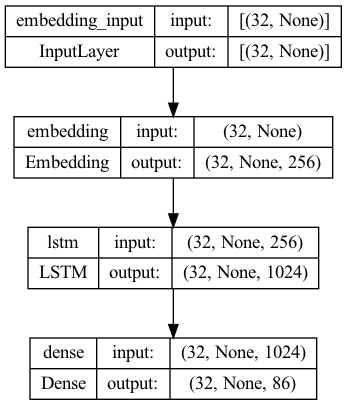

In [46]:
# !pip install pydot
# !pip install graphviz

tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

In [47]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print("(batch_size, sequence_length, vocab_size) = ", example_batch_predictions.shape)

(batch_size, sequence_length, vocab_size) =  (32, 500, 86)


In [48]:
print('Prediction for the 1st letter of batch 1st sequence:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of batch 1st sequence:
tf.Tensor(
[ 2.6609777e-03 -4.0977853e-03  1.6481644e-03 -2.5033394e-03
  1.6772640e-03  4.1064867e-03 -4.0609734e-03  3.4345549e-03
 -2.8874658e-03  6.2779482e-03  3.0968019e-03  4.0243608e-03
 -4.1553965e-03 -3.6822204e-03  4.9273930e-03 -3.0180707e-03
  9.9015248e-05  3.2180076e-05 -1.2769136e-03 -3.8301807e-03
  7.5633614e-04 -2.9286896e-03  2.2591664e-03 -1.8471553e-03
 -3.5613028e-03  3.3399311e-03  7.5623931e-05  3.5880955e-03
  2.2603679e-03 -7.2711371e-03 -2.5320244e-03  9.6423621e-04
  2.6436374e-03 -2.2648596e-03  6.6945463e-04  1.4285495e-03
 -1.5609738e-03 -4.7598383e-03  7.4870622e-05 -7.3536660e-04
  4.6528862e-03  3.5212338e-03 -1.2191973e-04 -3.8568357e-03
 -2.1422638e-03 -1.1642801e-03 -5.9896440e-04  5.2938936e-03
 -2.3390278e-03 -7.8058913e-03 -2.5228148e-03 -3.9089592e-03
  9.9223759e-04  1.8883820e-03  3.1550024e-03 -3.5848022e-03
 -3.4276526e-03 -4.9364176e-03 -2.6462972e-04 -3.4895896e-03
  7.8855664e-06  3.13

## TRAINING

In [49]:
# An objective function with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=labels,
        y_pred=logits,
        from_logits=True
    )

    return entropy


example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Loss shape:       ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 500, 86)  # (batch_size, sequence_length, vocab_size)
Loss shape:        (32, 500)
scalar_loss:       4.453181


In [59]:
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # v2.11+ optimizer runs slowly on M1/M2 Macs
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.05)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [60]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [61]:
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [62]:
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, 'ckpt_rnn_{epoch}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [63]:
INITIAL_EPOCH = 0
EPOCHS_DELTA = 10
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = 200

# print('\n')
# print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
# print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
# print('EPOCHS:          ', EPOCHS)
# print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

In [64]:
history_1 = {}

In [ ]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

model_name = 'p2r_rnn_raw' + str(INITIAL_EPOCH) + '.h5'
model_1.save(model_name, save_format='h5')

Epoch 1/10
156/200 [======================>.......] - ETA: 2:09 - loss: nan

In [ ]:
# rnn_model_name = f'./models/p2r_lstm_{INITIAL_EPOCH}.h5'
# model_1.save(rnn_model_name, save_format='h5')

## VISUALIZATION

In [ ]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

In [ ]:
render_training_history(history_1)

## GENERATING A RECIPE

In [ ]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)
model_1_simplified.load_weights(tf.train.latest_checkpoint(CHECKPOINT_DIR))
model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
model_1_simplified.summary()

In [ ]:
model_1_simplified.input_shape

In [ ]:
model_name = 'p2r_rnn_2.h5'
model_1_simplified.save(model_name, save_format='h5')

# ------

In [ ]:
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
    """
    Parameters:
        - num_generate: number of characters to generate.
        - temperature: 
            - Low temperatures results in more predictable text.
            - Higher temperatures results in more surprising text.
    """
    # Evaluation step
    padded_start_string = MARKER_TITLE + start_string

    # Vectorizing
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        predictions = tf.squeeze(predictions, 0)  # remove the batch dimension

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # Pass predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]
        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [ ]:
def generate_combinations(model, input_list):
    recipe_length = 1000
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for entry in input_list:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=entry,
                num_generate=recipe_length,
                temperature=temperature
            )

            print('---------')
            print(f'Attempt: "{entry}" + {temperature}')
            print('---------')
            print(generated_text)
            print('\n\n')

In [ ]:
input_ingredients1 = ['avocado', 'rice', 'shrimp', 'tomato'] 
generate_combinations(model_1_simplified, input_ingredients1)

In [ ]:
input_ingredients2 = ['Mushroom', 'Apple', 'Slow', 'Banana', 'Homemade']
generate_combinations(model_1_simplified, input_ingredients2)

In [ ]:
input_ingredients1 = ['avocado', 'rice', 'shrimp', 'tomato'] 
generate_combinations(model_1_simplified, input_ingredients1)

## Save

In [ ]:
# !pip install -U notebook-as-pdf
# !conda install -c conda-forge pandoc

nb_name = f"./nlp/P2R_lstm_2.ipynb"  # notebook name
!jupyter-nbconvert --to pdf ./nlp/P2R_lstm_2.ipynb
!jupyter-nbconvert --to html ./nlp/P2R_lstm_2.ipynb